<h1><span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#HSV" data-toc-modified-id="HSV-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>HSV</a></span></li><li><span><a href="#Sample" data-toc-modified-id="Sample-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sample</a></span></li><li><span><a href="#Color-Spaces" data-toc-modified-id="Color-Spaces-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Color Spaces</a></span><ul class="toc-item"><li><span><a href="#RGB-Color-Space" data-toc-modified-id="RGB-Color-Space-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>RGB Color Space</a></span></li><li><span><a href="#HSV-Color-Space" data-toc-modified-id="HSV-Color-Space-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>HSV Color Space</a></span></li></ul></li><li><span><a href="#Recognize-Dining-Plate" data-toc-modified-id="Recognize-Dining-Plate-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Recognize Dining Plate</a></span></li><li><span><a href="#References" data-toc-modified-id="References-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# 餐盘颜色识别

In [112]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -v -p numpy,sklearn,pandas
%watermark -v -p cv2,PIL,matplotlib
%watermark -v -p torch,torchvision,torchaudio
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.use_jedi = False

from IPython.display import display, HTML, Javascript
display(HTML('<style>.container { width:%d%% !important; }</style>' % 80))

def _IMPORT_(x):
    try:
        exec(x, globals())
    except:
        pass


CPython 3.6.9
IPython 7.16.1

numpy 1.19.4
sklearn 0.24.0
pandas 1.1.5
CPython 3.6.9
IPython 7.16.1

cv2 4.5.1
PIL 6.2.2
matplotlib 3.3.3
CPython 3.6.9
IPython 7.16.1

torch 1.8.0.dev20210103+cu101
torchvision 0.9.0.dev20210103+cu101
torchaudio not installed


In [123]:
###
### Common ###
###

import sys, os, io, time, random, math
import json, base64, requests
import os.path as osp

_IMPORT_('import numpy as np')
_IMPORT_('import pandas as pd')
_IMPORT_('from tqdm.notebook import tqdm')

def print_progress_bar(x):
    print('\r', end='')
    print('Progress: {}%:'.format(x), '%s%s' % ('▋'*(x//2), '.'*((100-x)//2)), end='')
    sys.stdout.flush()

###
### Display ###
###

_IMPORT_('import cv2')
_IMPORT_('from PIL import Image')
_IMPORT_('from torchvision.utils import make_grid')
_IMPORT_('import matplotlib.pyplot as plt')
_IMPORT_('import plotly')
_IMPORT_('import plotly.graph_objects as go')

# plotly.offline.init_notebook_mode(connected=False)

plt.rcParams['figure.figsize'] = (12.0, 8.0)

def show_video(video_path, width=None, height=None):
    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if video_path.startswith('http'):
        data_url = video_path
    else:
        mp4 = open(video_path, 'rb').read()
        data_url = 'data:video/mp4;base64,' + base64.b64encode(mp4).decode()
    return HTML('<video %s %s controls src="%s" type="video/mp4"/>' % (W, H, data_url))

def show_image(image_path, width=None, height=None):
    if isinstance(image_path, np.ndarray):
        img = image_path
        if width or height:
            if width and height:
                size = (width, height)
            else:
                rate = img.shape[1] / img.shape[0]
                if width:
                    size = (width, int(width/rate))
                else:
                    size = (int(height*rate), height)
            img = cv2.resize(img, size)
            plt.figure(figsize=(3*int(size[0]/80+1), 3*int(size[1]/80+1)), dpi=80)
        plt.axis('off')
        if len(img.shape) > 2:
            plt.imshow(img);
        else:
            plt.imshow(img, cmap='gray');
        return

    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if image_path.startswith('http'):
        data_url = image_path
    else:
        img = open(image_path, 'rb').read()
        data_url = 'data:image/jpg;base64,' + base64.b64encode(img).decode()
    return HTML('<img %s %s src="%s"/>' % (W, H, data_url))

def im_read(url, rgb=True, size=None):
    response = requests.get(url)
    if response:
        imgmat = np.frombuffer(response.content, dtype=np.uint8)
        img = cv2.imdecode(imgmat, cv2.IMREAD_COLOR)
        if rgb:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if size:
           if isinstance(size, int):
               size = (size, size)
           img = cv2.resize(img, size)
        return img
    return None


from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

## HSV


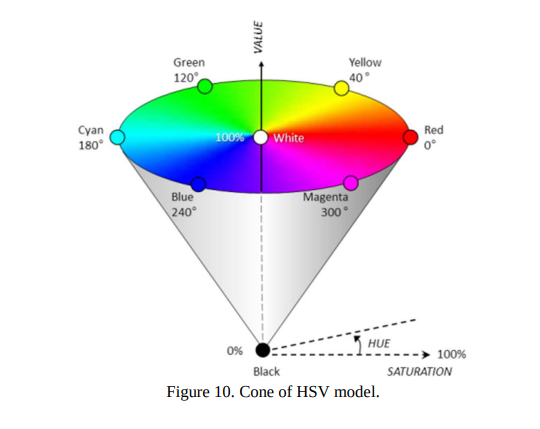

In [3]:
show_image('hsv.png')


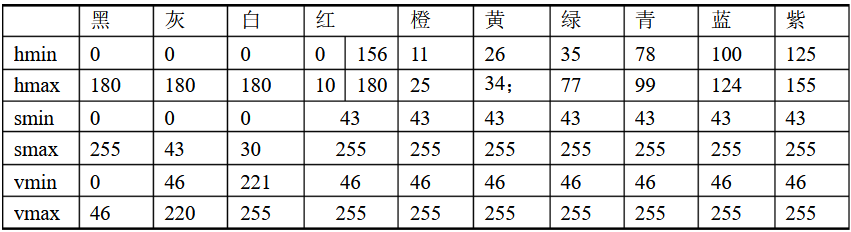

In [4]:
show_image('hsv_range.png')

## Sample

In [50]:
test_samples = [
    'https://raceai.s3.didiyunapi.com/data/datasets/cv/dining_plate/blue_plate_1.jpg',
    'https://raceai.s3.didiyunapi.com/data/datasets/cv/dining_plate/blue_plate_3.jpg',
    'https://raceai.s3.didiyunapi.com/data/datasets/cv/dining_plate/blue_plate_4.jpg',
    'https://raceai.s3.didiyunapi.com/data/datasets/cv/dining_plate/green_plate_1.jpg',
    'https://raceai.s3.didiyunapi.com/data/datasets/cv/dining_plate/green_plate_2.jpg',
    'https://raceai.s3.didiyunapi.com/data/datasets/cv/dining_plate/red_plate_1.jpg',
    'https://raceai.s3.didiyunapi.com/data/datasets/cv/dining_plate/white_plate_1.jpg',
    'https://raceai.s3.didiyunapi.com/data/datasets/cv/dining_plate/yellow_plate_1.jpg',
]

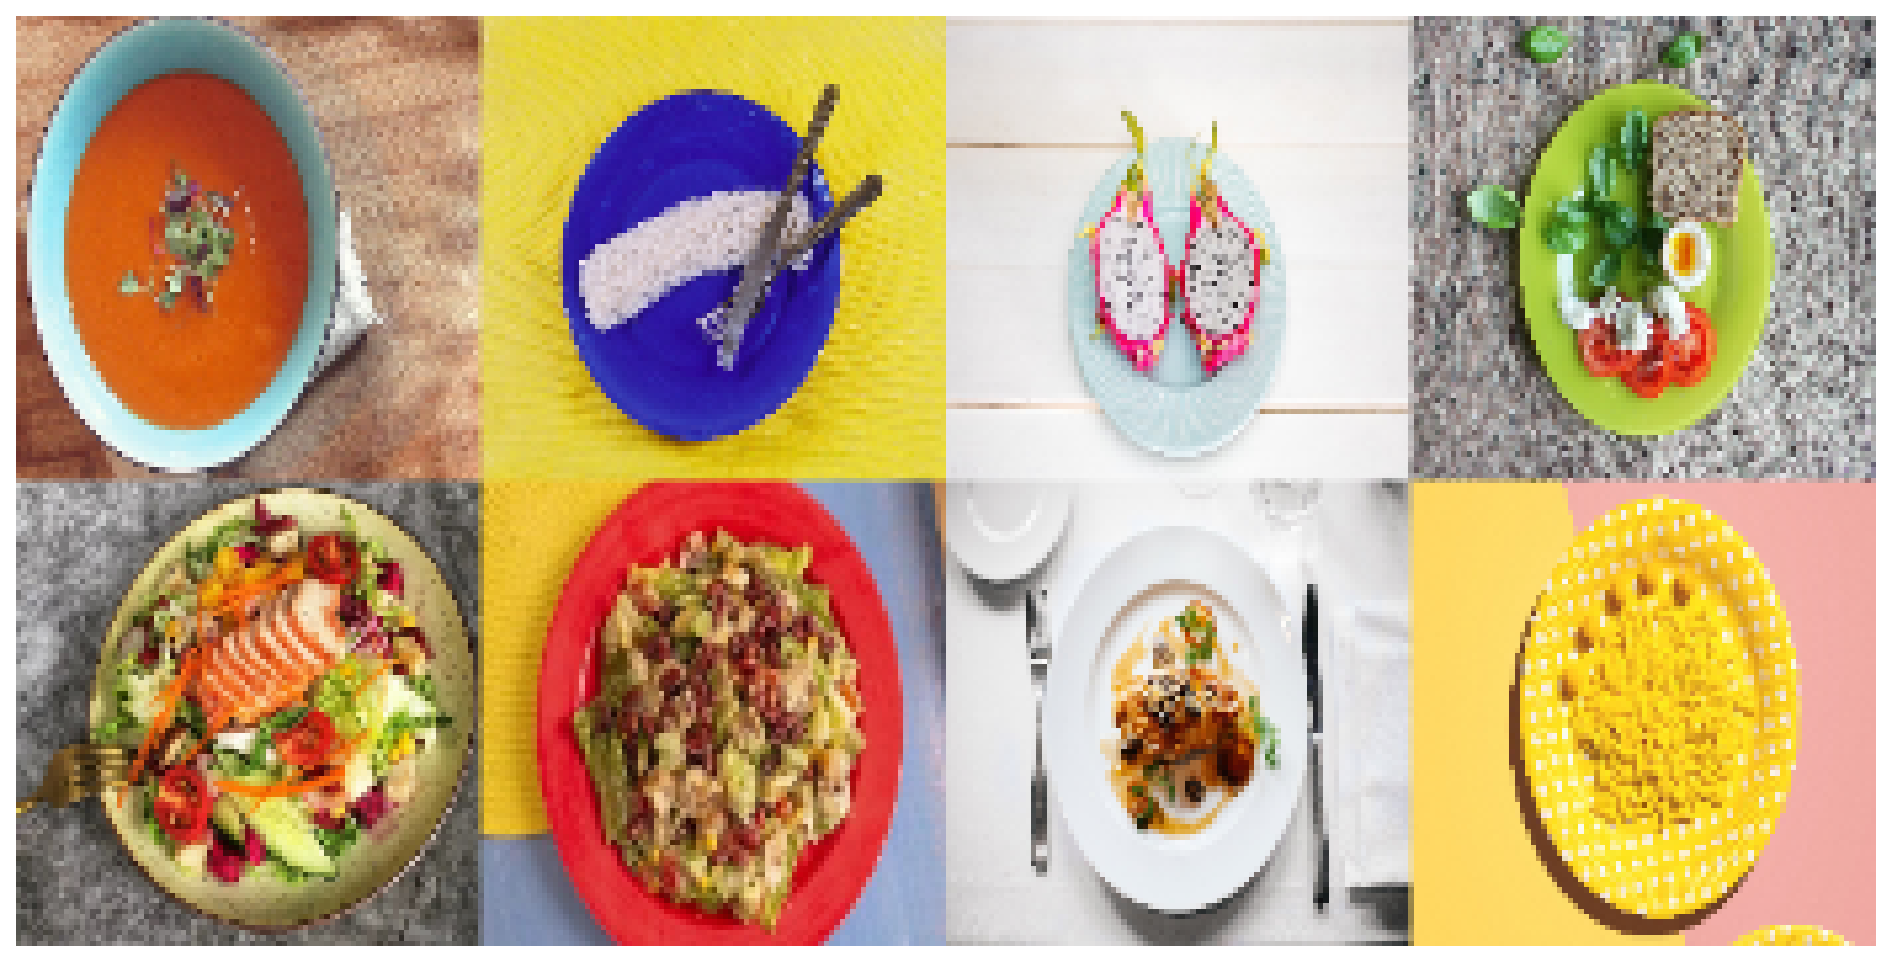

In [124]:
show_image(np.vstack([
    np.hstack([
        im_read(test_samples[0], size=150),
        im_read(test_samples[1], size=150),
        im_read(test_samples[2], size=150),
        im_read(test_samples[3], size=150)]),
    np.hstack([
        im_read(test_samples[4], size=150),
        im_read(test_samples[5], size=150),
        im_read(test_samples[6], size=150),
        im_read(test_samples[7], size=150)])
    ]), width=350)

In [9]:
hsv_yellow_lower = np.array([26, 43, 46])
hsv_yellow_upper = np.array([34, 255, 255])

hsv_green_lower = np.array([35, 43, 46])
hsv_green_upper = np.array([77, 255, 255])

# hsv_blue_lower = np.array([100, 43, 46])
# hsv_blue_upper = np.array([124, 255, 255])

hsv_blue_lower = np.array([30, 43, 46])
hsv_blue_upper = np.array([124, 255, 255])

hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, lowerb=hsv_blue_lower, upperb=hsv_blue_upper)
# mask = cv2.inRange(hsv, lowerb=hsv_green_lower, upperb=hsv_green_upper)
# mask = cv2.inRange(hsv, lowerb=hsv_yellow_lower, upperb=hsv_yellow_upper)

dst = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)

rgb_img = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# show_image(rgb_img)

In [14]:
rgb_img.shape

(861, 1270, 3)

## Color Spaces

In [12]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

w, h, c = img_rgb.shape
pixel_colors = img_rgb.reshape(-1, c)
norm = colors.Normalize(vmin=0., vmax=1.)
norm.autoscale(pixel_colors) # set: vmin = np.min(pixel_colors), vmax = np.max(pixel_colors)
# norm = colors.Normalize(vmin=0., vmax=255.)
pixel_colors = norm(pixel_colors).tolist()

### RGB Color Space

Text(0.5, 0, 'B')

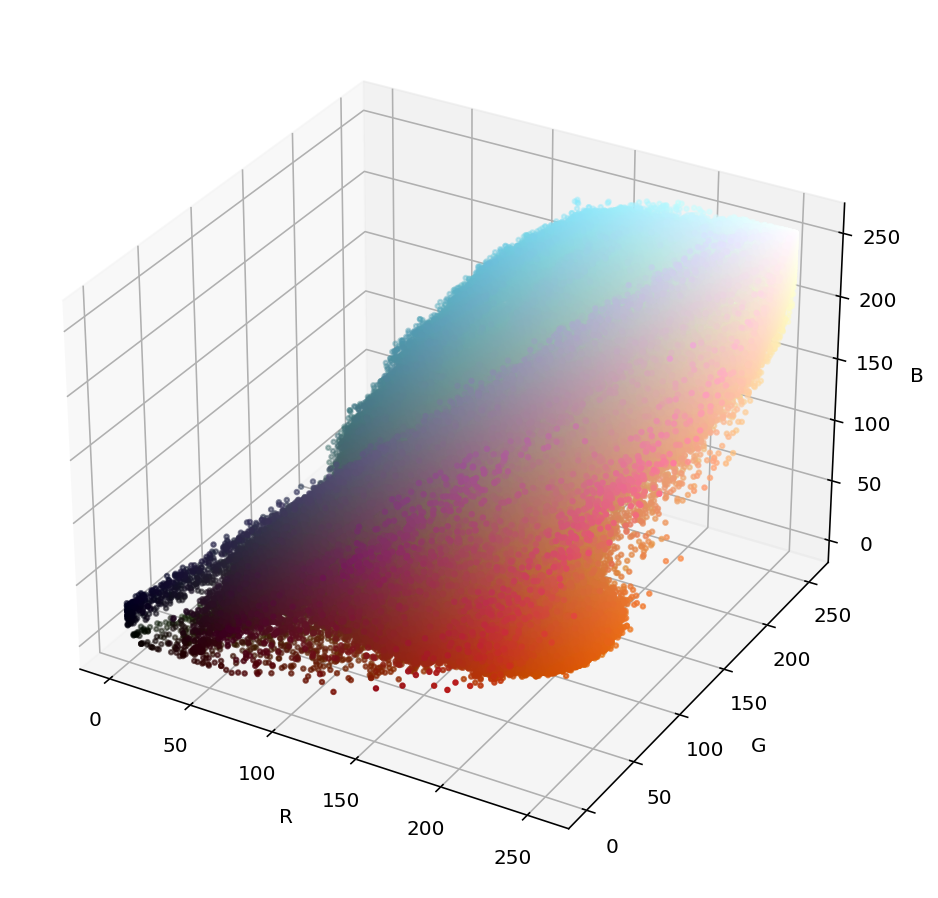

In [15]:
r, g, b = cv2.split(img_rgb) 

fig = plt.figure(figsize=(8, 8))
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("R")
axis.set_ylabel("G")
axis.set_zlabel("B");

### HSV Color Space

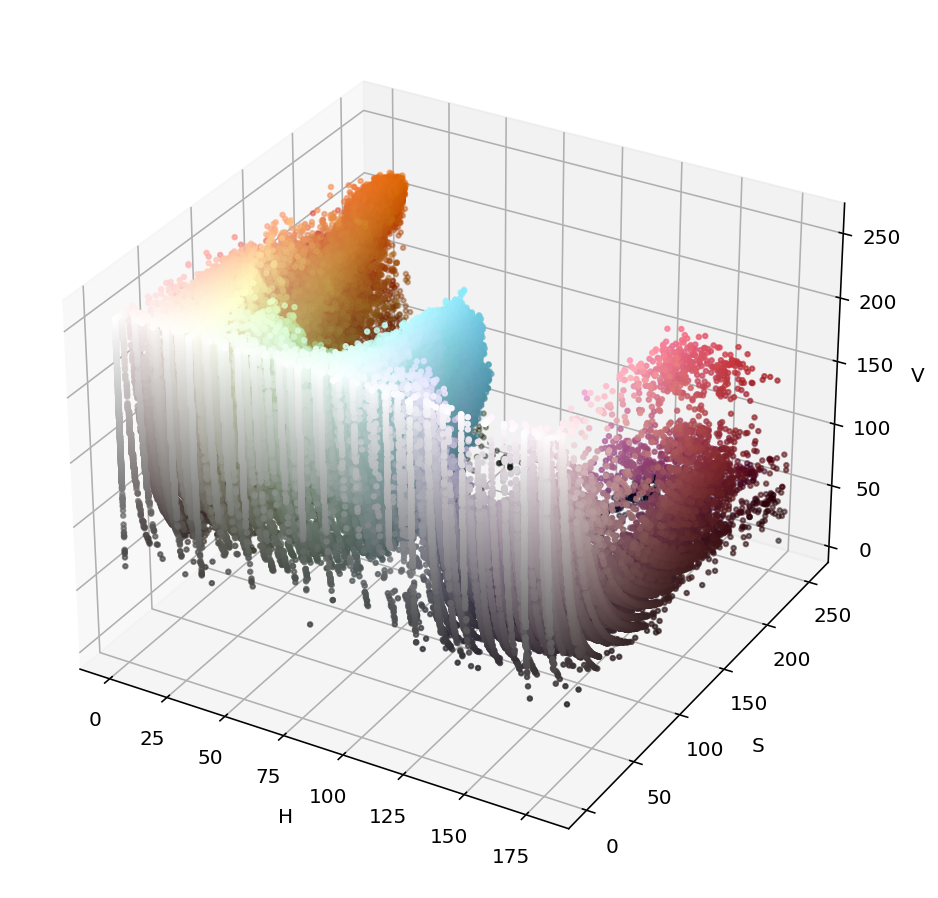

In [17]:
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

h, s, v = cv2.split(img_hsv)

fig = plt.figure(figsize=(8, 8))
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("H")
axis.set_ylabel("S")
axis.set_zlabel("V");

## Recognize Dining Plate 

In [126]:
def image_process(img_path):
    img_rgb = im_read(img_path)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    img_clahe = cv2.createCLAHE(
        clipLimit=5.0, tileGridSize=(10, 10)
    ).apply(img_gray)
    img_blur = cv2.bilateralFilter(img_clahe, d=20, sigmaColor=97, sigmaSpace=50)
    img_bin = cv2.adaptiveThreshold(
        img_blur, 225,
        cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 7, 2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    img_morph = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel, iterations=2)
    images = np.vstack([
        np.hstack([img_gray, img_clahe, img_blur, img_bin, img_morph]),
    ])
    return images

def image_canny(img_path):
    img_rgb = im_read(img_path)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    blurred = cv2.blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)
    wide = cv2.Canny(blurred, 10, 200)
    mid = cv2.Canny(blurred, 30, 150)
    tight = cv2.Canny(blurred, 240, 250)
    return np.hstack([wide, mid, tight])

# conts = cv2.findContours(img_morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
# for c in conts:
#     (x, y, w, h) = cv2.boundingRect(c)
#     print(x, y, w, h)
#     cv2.rectangle(img_gray, (x, y), (x + w, y + h), (0, 255,0), 1)
    

# images, image_process(im_read(test_samples[0]))

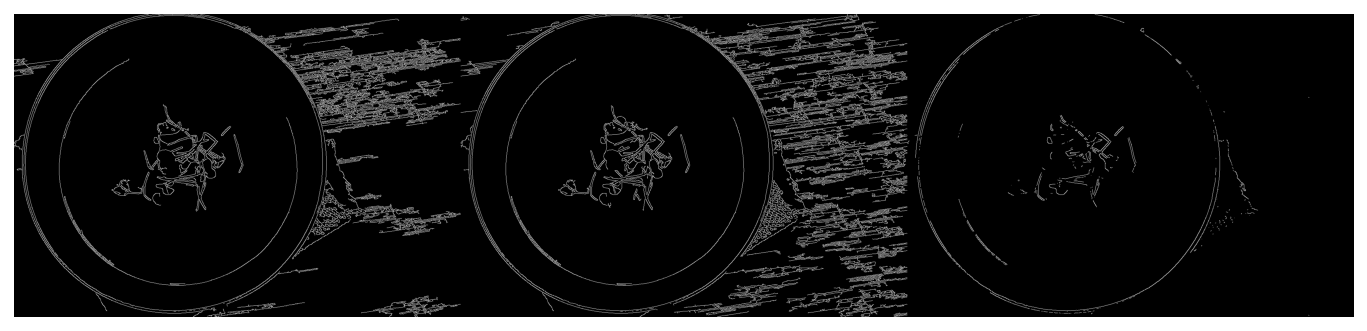

In [99]:
show_image(image_canny(test_samples[0]))

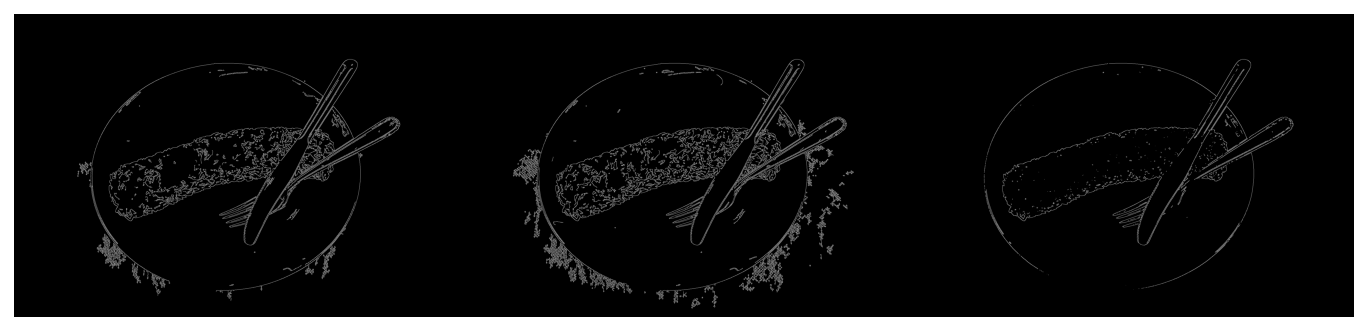

In [100]:
show_image(image_canny(test_samples[1]))

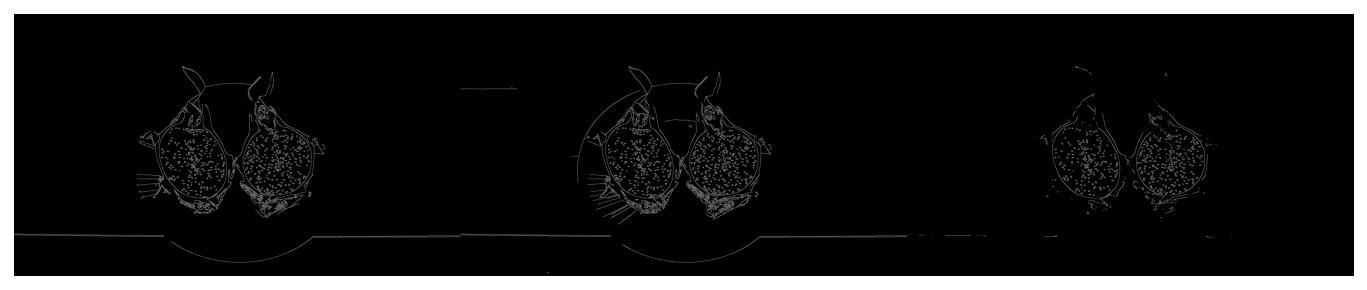

In [101]:
show_image(image_canny(test_samples[2]))

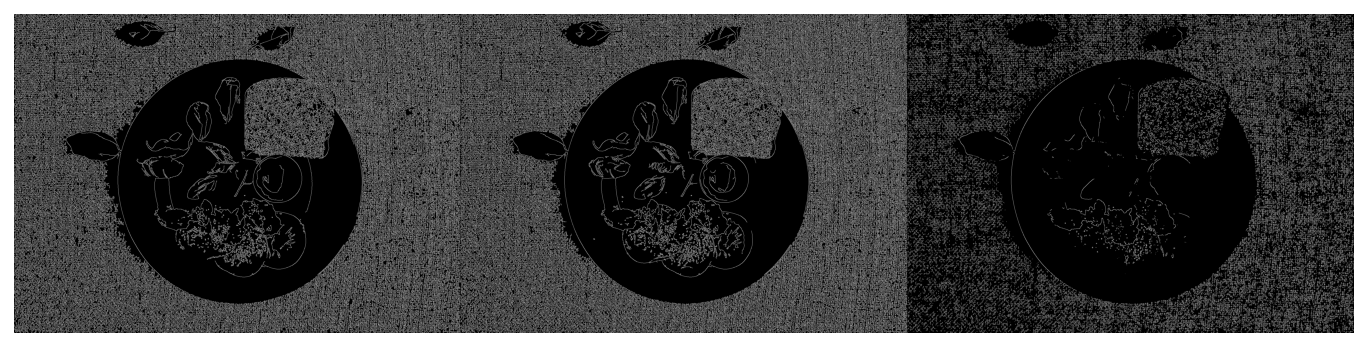

In [102]:
show_image(image_canny(test_samples[3]))

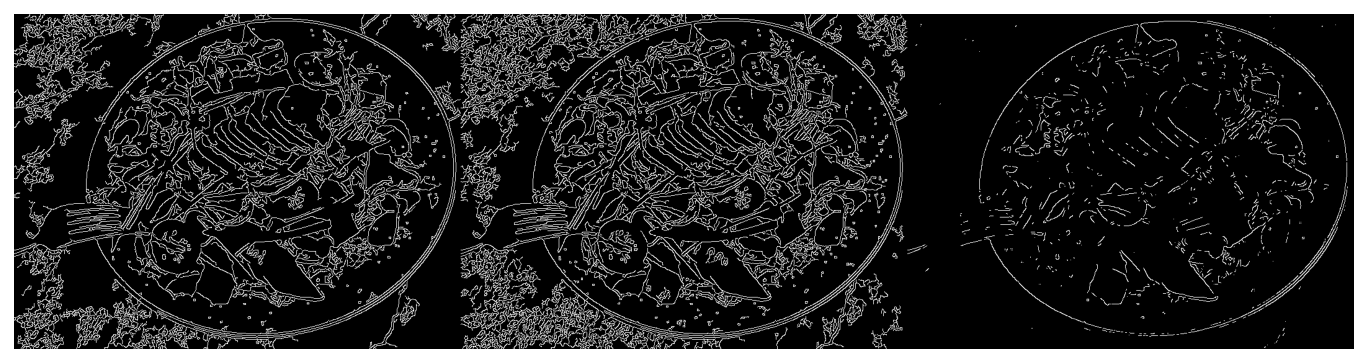

In [106]:
show_image(image_canny(test_samples[4]))

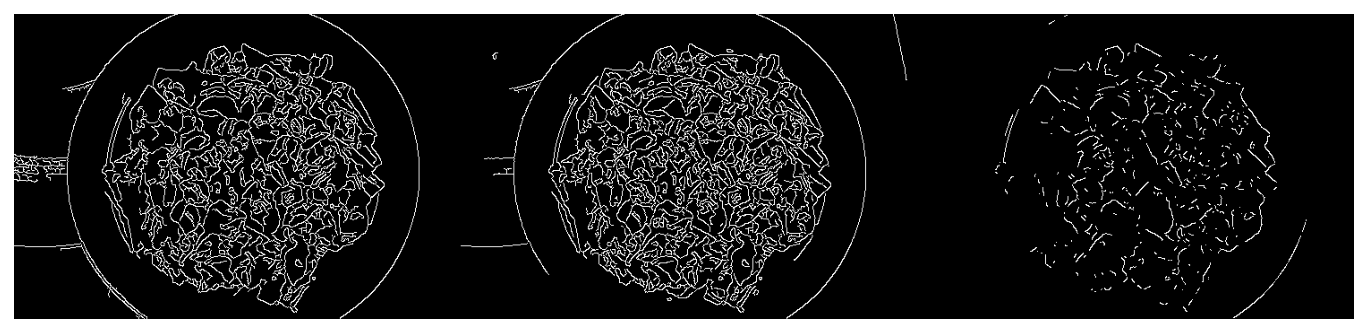

In [105]:
show_image(image_canny(test_samples[5]))

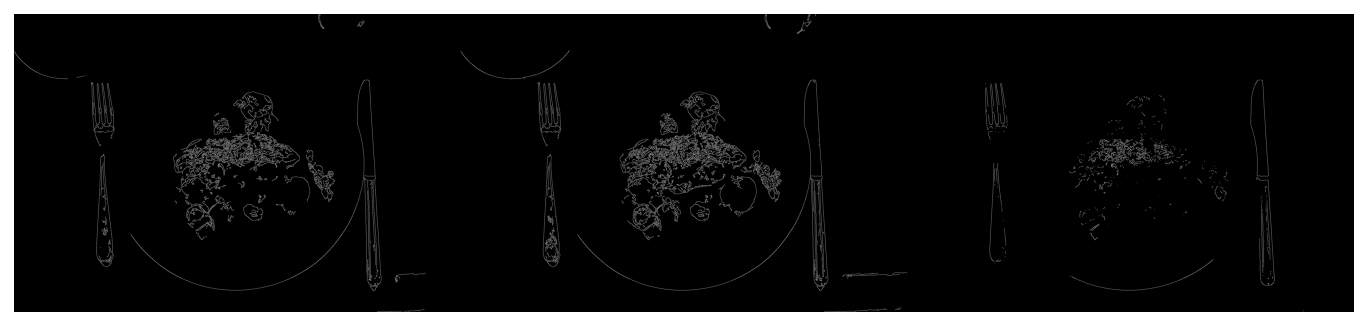

In [104]:
show_image(image_canny(test_samples[6]))

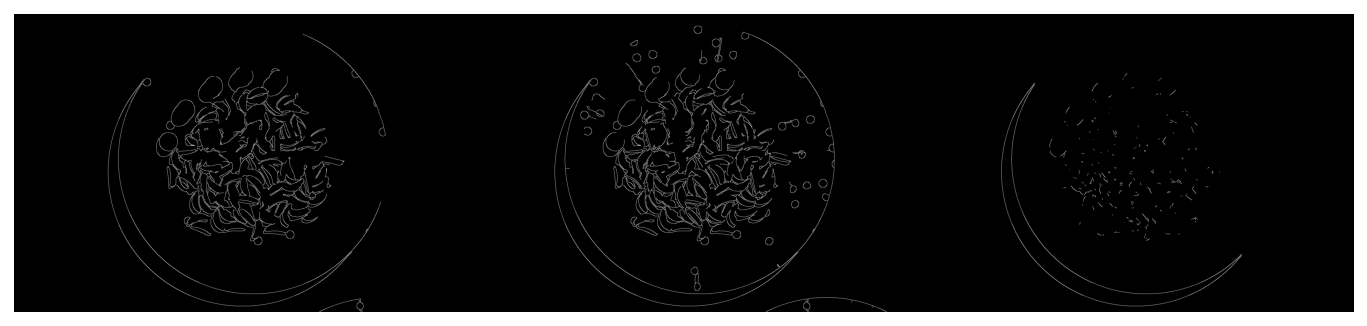

In [103]:
show_image(image_canny(test_samples[7]))

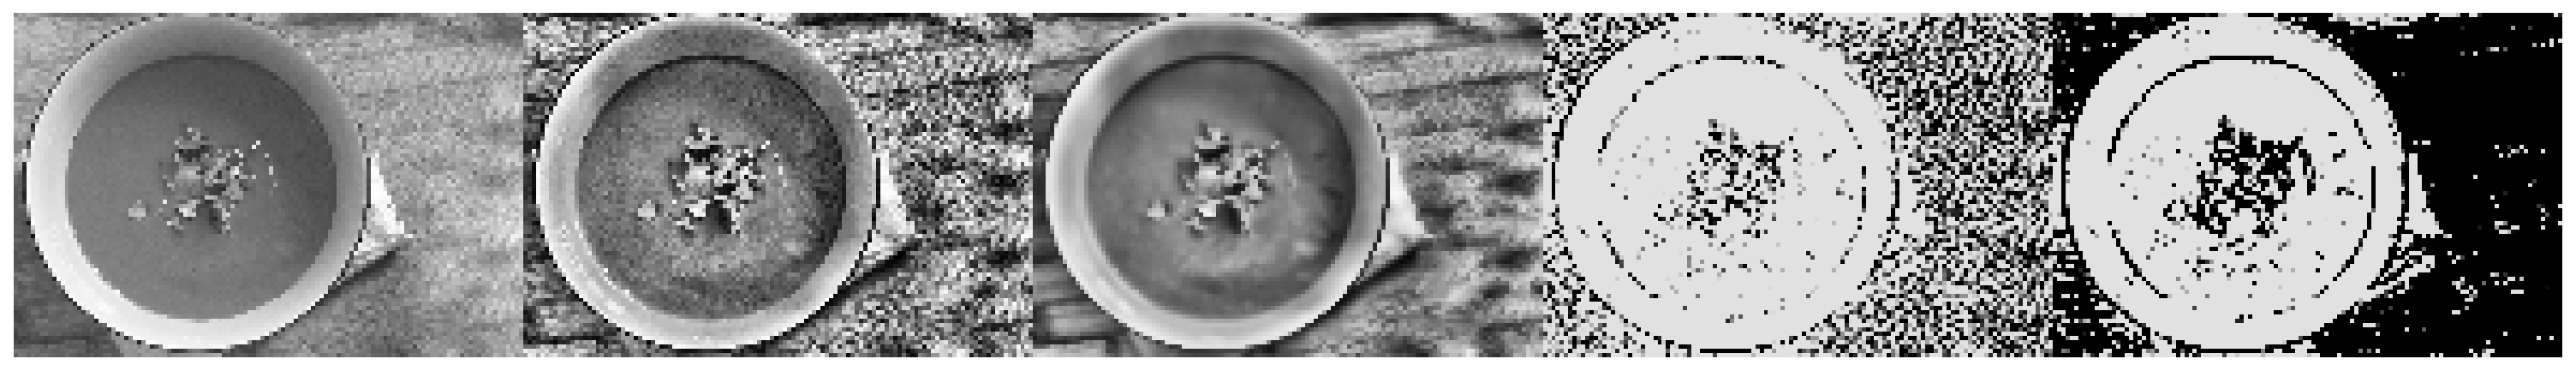

In [127]:
show_image(image_process(test_samples[0]), width=600)

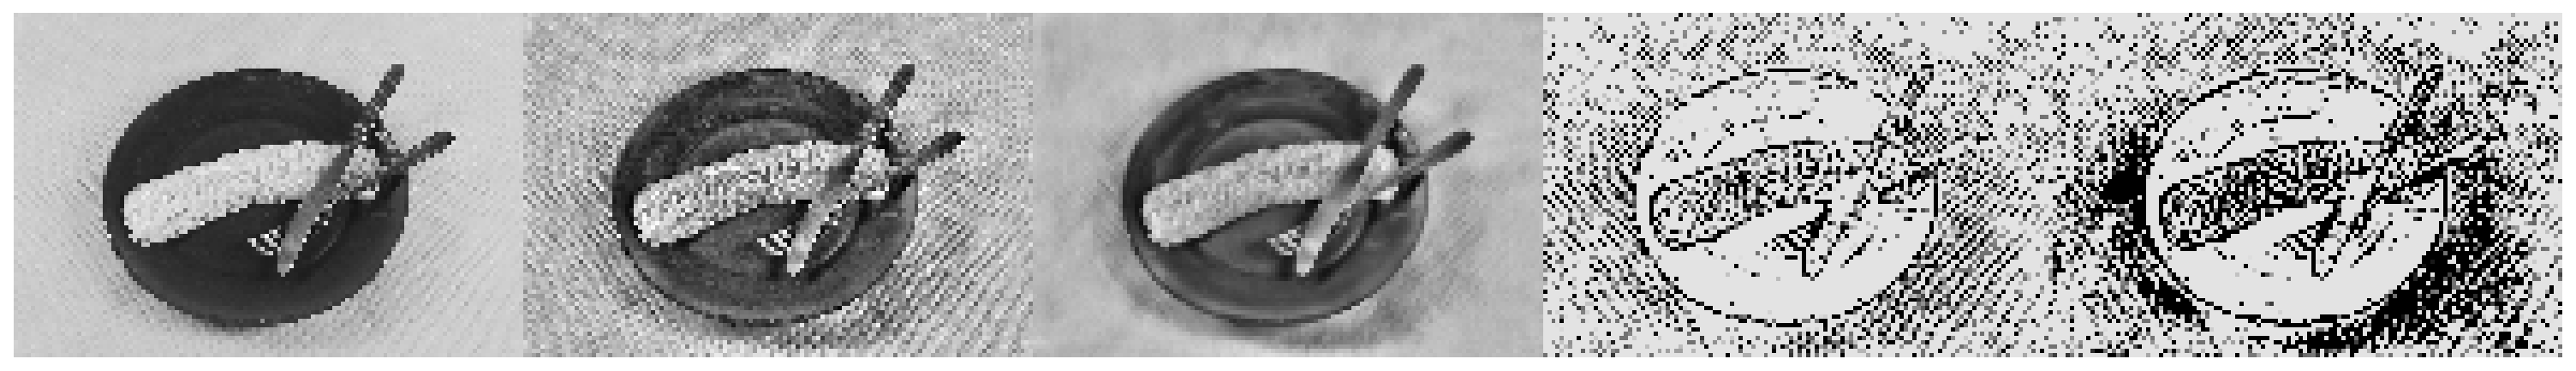

In [64]:
show_image(image_process(test_samples[1]), width=600)

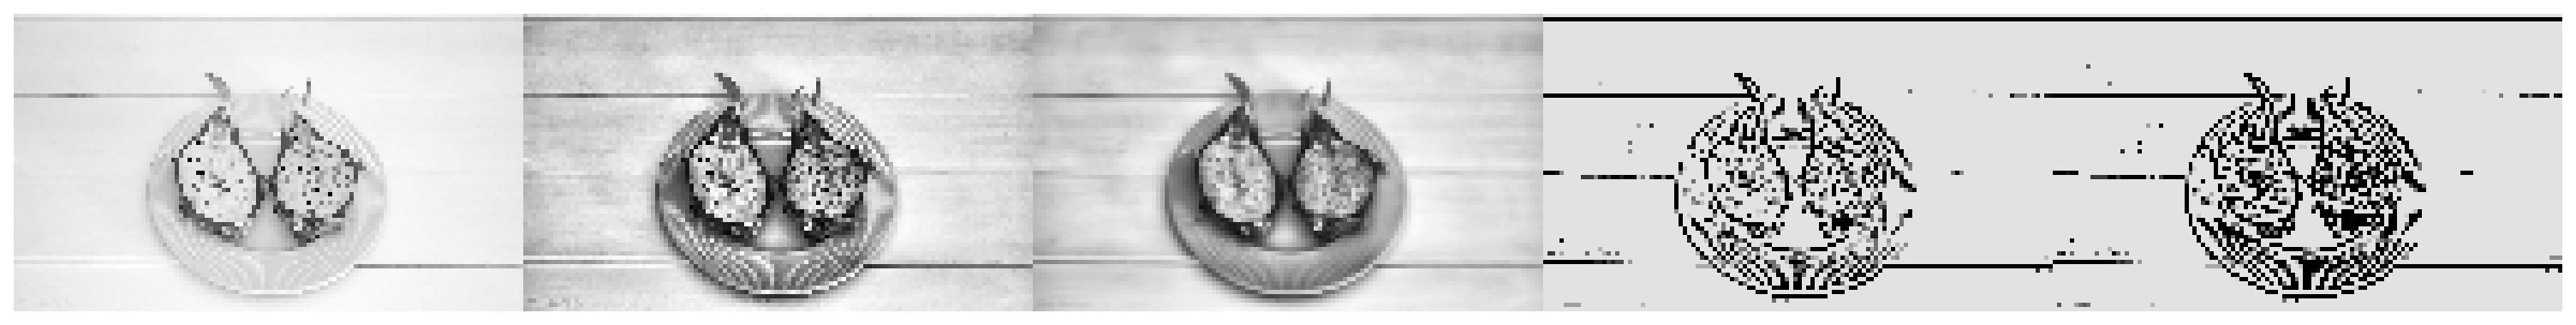

In [63]:
show_image(image_process(test_samples[2]), width=600)

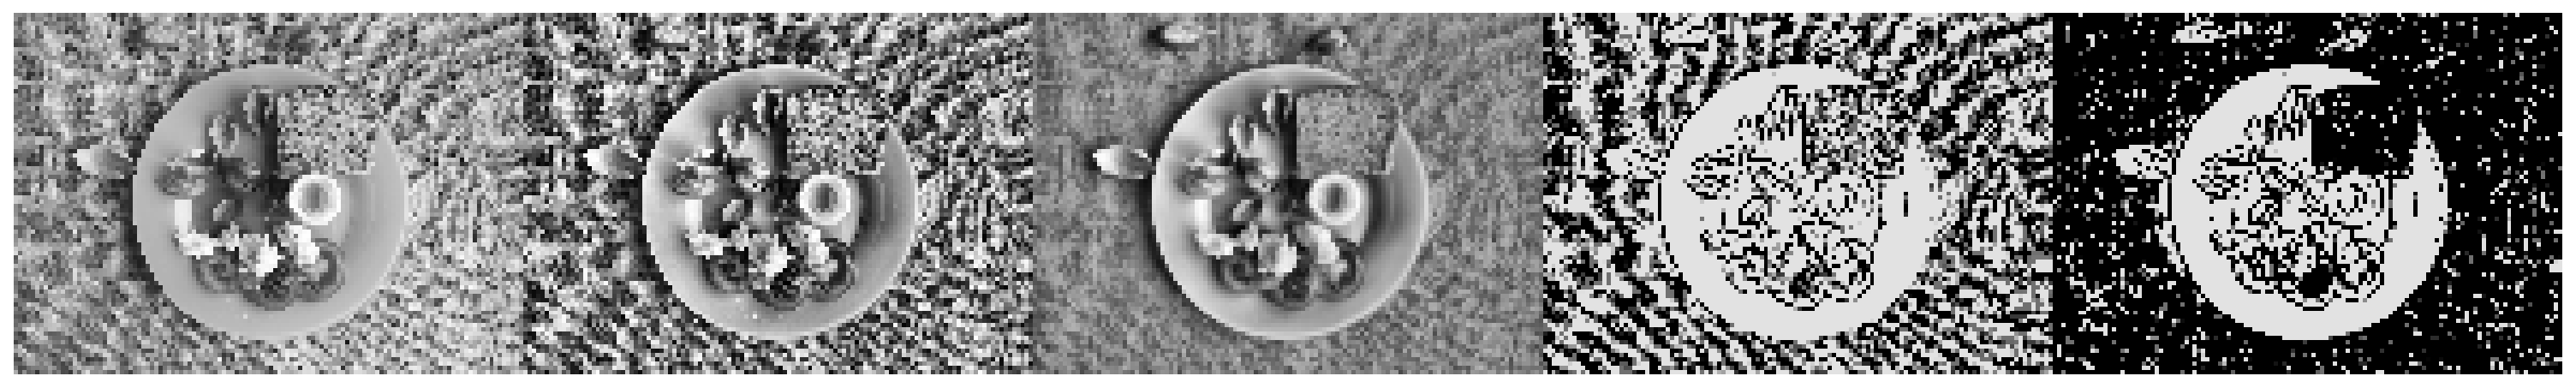

In [62]:
show_image(image_process(test_samples[3]), width=600)

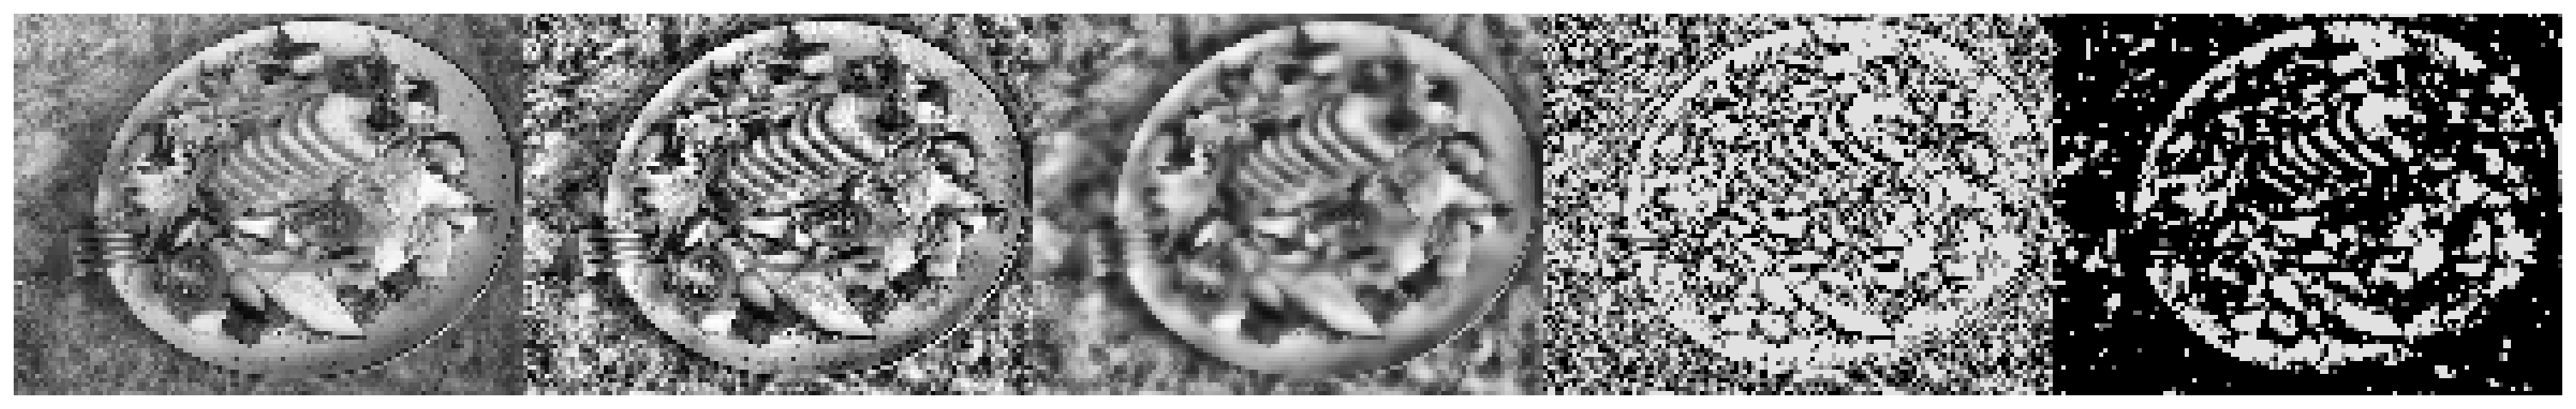

In [71]:
show_image(image_process(test_samples[4]), width=600)

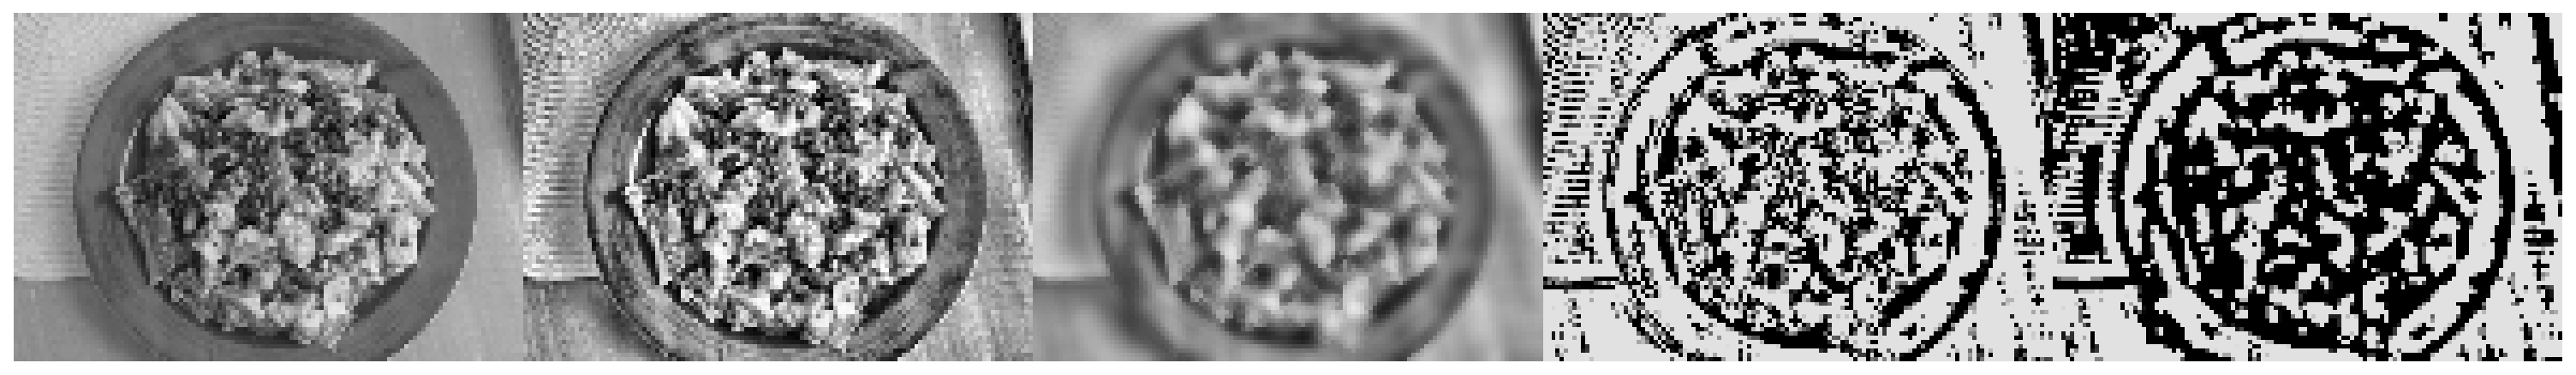

In [61]:
show_image(image_process(test_samples[5]), width=600)

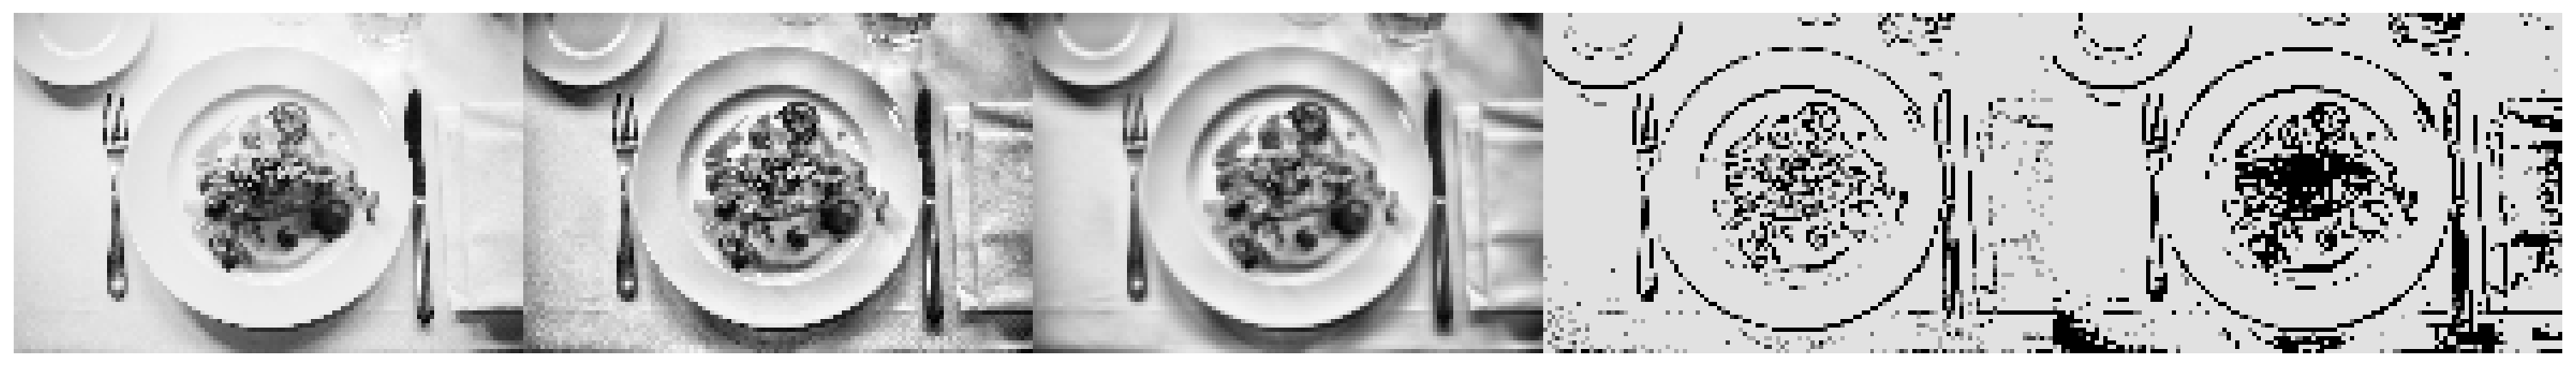

In [53]:
show_image(image_process(test_samples[6]), width=600)

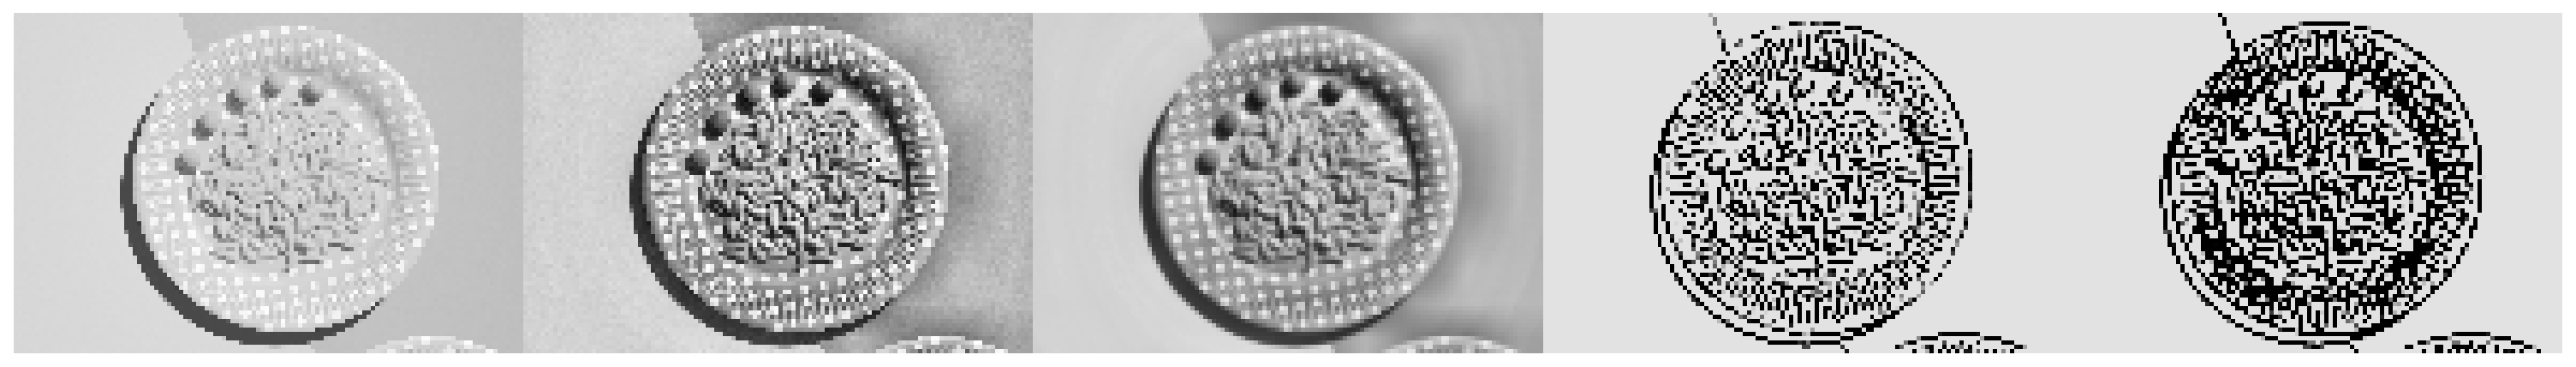

In [54]:
show_image(image_process(test_samples[7]), width=600)

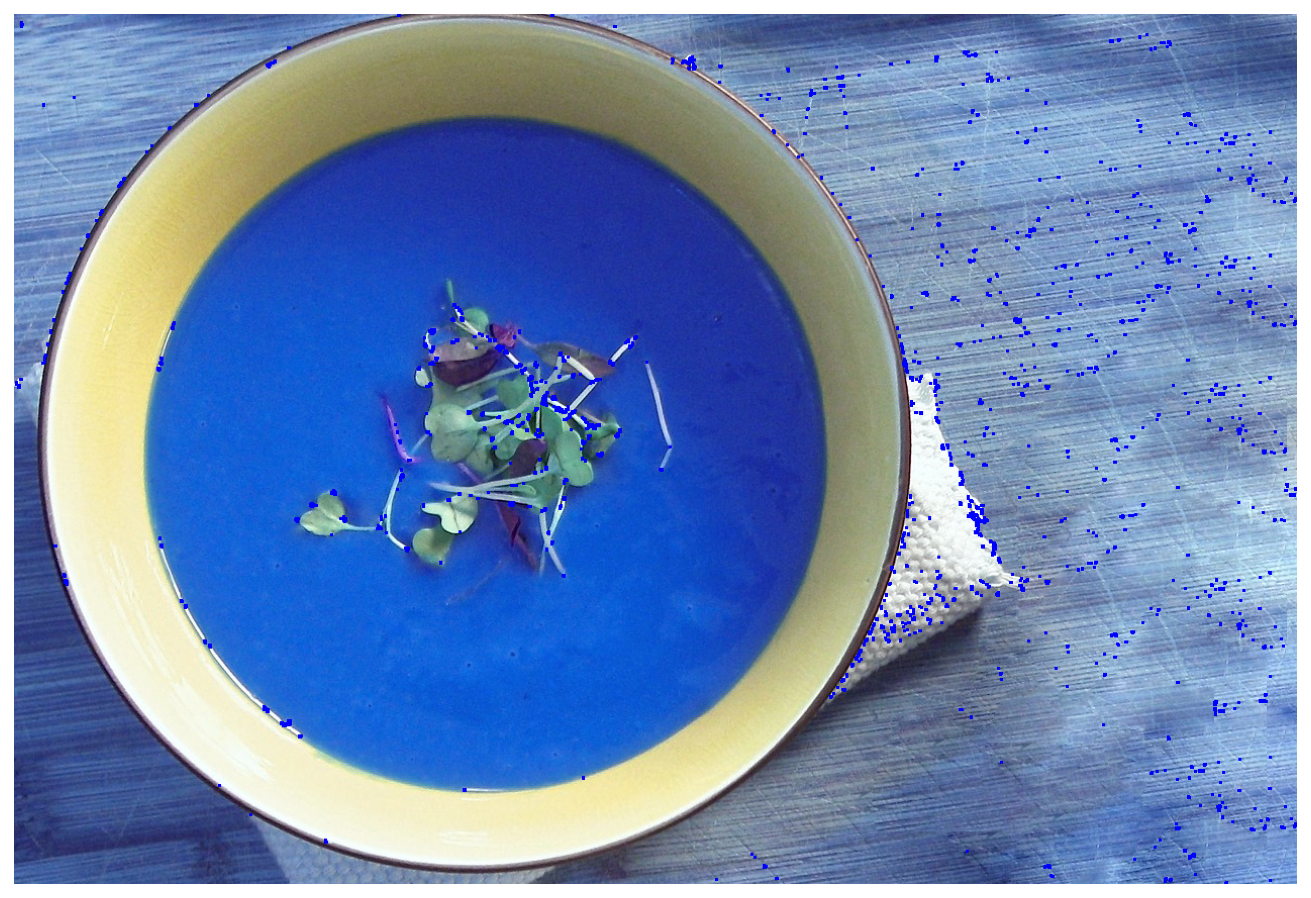

In [85]:
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
 
gray = np.float32(gray)

dst = cv2.cornerHarris(gray,2,3,0.04)
 
#result is dilated for marking the corners, not important
dst = cv2.dilate(dst, None)
 
# Threshold for an optimal value, it may vary depending on the image.
img_bgr[dst>0.01*dst.max()] = [0,0,255]

show_image(img_bgr)

## References

1. http://oa.upm.es/40591/3/TFG_JULIAN_CALDERON_GONZALEZ.pdf

2. https://realpython.com/python-opencv-color-spaces/

3. https://blog.csdn.net/eternity1118_/article/details/51492105

4. https://medium.com/analytics-vidhya/morphological-transformations-of-images-using-opencv-image-processing-part-2-f64b14af2a38

5. https://python.plainenglish.io/complete-understanding-of-morphological-transformations-in-image-processing-eadb337e9d5c

6. cv2.copyMakeBorder() https://my.oschina.net/u/4870686/blog/4956432

7. Canny原理:https://www.pyimagesearch.com/2021/05/12/opencv-edge-detection-cv2-canny/

8. 边缘类型 https://blog.csdn.net/wsp_1138886114/article/details/82935839